In [1]:
# Import basic libraries

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import joblib

print(tf.__version__)

2.10.0


In [2]:
# Define some helper functions

def plot_predictions(labels, predictions):
    plt.scatter(labels, predictions)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100])

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def norm(x, stats):
  return (x - stats['mean']) / stats['std']

def build_model(train_dataset):
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [3]:
# Download Dataset

url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(url, names=column_names, na_values = "?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()

In [4]:
# Delete all null/undefined values

dataset = dataset.dropna()

In [5]:
# Transform category origin data into numerical data

origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

In [6]:
# Get Train and Test Datasets

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [7]:
# Describe 

train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()

In [8]:
# Get Labels

train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [9]:
# Normalize Train and Test Data
normed_train_data = norm(train_dataset, train_stats)
normed_test_data = norm(test_dataset, train_stats)

In [10]:
# Define Training Epochs

EPOCHS = 1000

2023-06-14 17:44:51.406392: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz



.....................................................................................

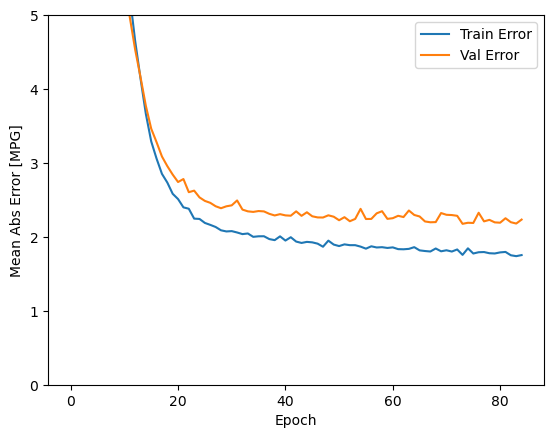

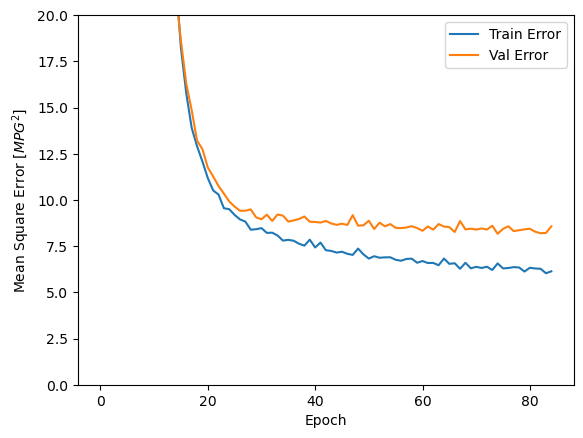

In [11]:
# Add Early Stop to the model generation

model = build_model(normed_train_data)

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [12]:
# Eval our model results

loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.4968 - mae: 2.0217 - mse: 6.4968 - 10ms/epoch - 3ms/step
Testing set Mean Abs Error:  2.02 MPG


3/3 [==============================] - 0s 676us/step


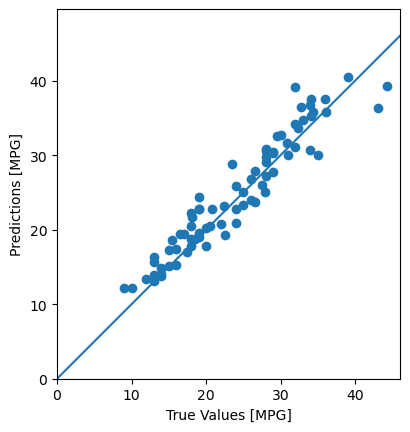

In [13]:
test_predictions = model.predict(normed_test_data).flatten()
plot_predictions(test_labels, test_predictions)

In [14]:
# Export Model
model_path = '../../trained/regresion-model.joblib'

joblib.dump(model, model_path)

INFO:tensorflow:Assets written to: ram://6bc311e5-f9ff-45a6-86f2-62d9a2ccddbf/assets


['../../trained/regresion-model.joblib']

In [15]:
# Import Model
trained_moded = joblib.load(model_path)

3/3 [==============================] - 0s 613us/step


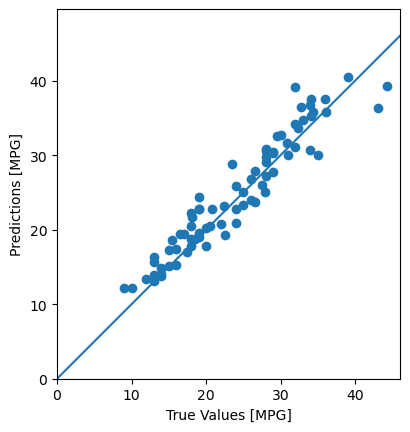

In [16]:
test_predictions = trained_moded.predict(normed_test_data).flatten()
plot_predictions(test_labels, test_predictions)